# Electricity Consumption Model: Work in Progress

## Setup

In [2]:
# Importing libraries 
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import datetime
import warnings
import random
import os
import scipy
import seaborn as sns

# Squash warning messages for cleaner output in the notebook
warnings.showwarning = lambda *args, **kwargs: None

## Defining Functions

### Preprocessing

In [ ]:
# Function creating a (hopefully) cleaner dataframe of load profiles
# from a csv-path. Printing of info is by default False and deleting
# zero columns with 25% zeros set to True. Developed for the format of
# the csv-files from Gudmund. 

def clean_gudmund_csv(csv_path, prnt = False, del_zeros_all = False, del_zeros_percent = True, 
                      interpolate = True, percent_drop_zeros = 0.25):
    
    dataframe = pd.read_csv(csv_path, index_col=0, parse_dates=True)
    drop_thresh_row = int(dataframe.shape[1]*0.80) #drop if ~20% of row is empty
    dataframe.dropna(axis=0, thresh = drop_thresh_row, inplace=True) #first row
    
    drop_thresh_col = int(dataframe.shape[0]*0.90) #drop if ~10% of column is empty
    dataframe.dropna(axis=1, thresh = drop_thresh_col, inplace=True) #then col
    
    if del_zeros_percent: #delete columns with a percentage of zeros
        drop_zero_cols = dataframe.columns[(dataframe == 0).sum() > percent_drop_zeros*dataframe.shape[1]]
        dataframe.drop(drop_zero_cols, axis = 1, inplace = True)
    elif del_zeros_all: #delete columns with ALL zeros
        dataframe = dataframe.loc[:, (dataframe != 0).any(axis=0)] 
        
    if interpolate: #linear interpolation for NaN values
        dataframe.interpolate(method='linear', axis=0, limit_direction = 'both', inplace = True)
    
    if prnt:
        start_time, end_time = dataframe.index[0], dataframe.index[-1]
        nan_indexes = dataframe.loc[pd.isnull(dataframe).any(1), :].index #not printing but maybe useful
        number_missing = len(nan_indexes) 
        df_size = (dataframe.shape[0]-1)*(dataframe.shape[1]-1) #number of values
        percent = round(number_missing/df_size *100,3) #% with 3 decimals
        print('Dataframe with consumption from {} load, ({} to {}).'.format(dataframe.shape[1],start_time,end_time))
        print('Out of {} values, {} is missing ({} %).'.format(df_size,number_missing, percent))
    
    return dataframe

In [ ]:
# A function for dropping a percentage, which is by default 50%,
# of all columns by random. The renumber parameter renames the 
# columns 1...n if set to True. 

def drop_random_columns(dataframe, drop_percent = 0.5, renumber = False):
    number_to_drop = int(dataframe.shape[1]*drop_percent)
    columns_to_drop = random.sample(range(0, dataframe.shape[1]), number_to_drop)
    dataframe.drop(dataframe.columns[columns_to_drop],axis=1,inplace=True)
    
    if renumber:
        dataframe.columns = np.arange(1,len(dataframe.columns)+1)
    return dataframe

### Working with load curves

In [3]:
# Function which takes a dataframe where
# each column represents a load and rows = date/time
# returns same dataframe but with a aggregated column.

def add_aggregated_col(dataframe):
    dataframe.sort_index(inplace=True) # making sure df is sorted
    dataframe['AggregatedLoad'] = dataframe.sum(numeric_only=True, axis=1) # add new sum col
    return dataframe

In [4]:
# Takes a dataframe and returns a sorted list
# of the 'AggregtedLoad' column, which should be defined. 

def from_df_to_sorted_lst(dataframe):
    sorted_load_list = dataframe['AggregatedLoad'].sort_values().tolist()
    return sorted_load_list

In [5]:
# Function that takes a sorted list of load demand 
# values and produces a plot of the load duration curve.

def plot_load_duration_curve(sorted_demand_list):
    list_len = len(sorted_demand_list) #Number of datapoints
    x = np.linspace(1,list_len,list_len).tolist() #List of hours
    
    plt.plot(x,sorted_demand_list)
    plt.title('Load Duration curve')
    plt.xlabel('Hours')
    plt.ylabel('Consumption [kWh]') #Review if kwh or not later on

In [6]:
# Function which takes dataframe and calculates mean and standard deviation. 
# Plotting and printing is by default False. 

def calculate_norm_stats(dataframe, plot = False, prnt = False):
    start_date, end_date = dataframe.index[0].to_pydatetime().date(), dataframe.index[-1].to_pydatetime().date()
    agg_load_list = dataframe['AggregatedLoad'].tolist()
    mu, sigma = scipy.stats.norm.fit(agg_load_list)
    
    if plot: 
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        plt.plot(x, scipy.stats.norm.pdf(x, mu, sigma))
        plt.title('Gaussian distribution of hourly aggregated loads')
        plt.show()
        
    if prnt:
        print('Mean consumption from {} to {} is {} (-/+ {}).'.format(start_date,end_date,mu,sigma)) #add unit here
    
    return mu, sigma

In [7]:
# A function to copy a load profile with stochastic deviation
# from the original. The values varies according to a gaussian 
# distribution, with default and mu = 0, sigma = 0.1. The
# funtion returns a copy of the dataframe with the new column. 

def copy_load_stochastic(dataframe, column_name, sigma=0.1):
    
    min_prob, max_prob = -sigma, sigma
    prob_array = (max_prob - min_prob) * np.random.random_sample(size=dataframe.shape[0]) + min_prob
    new_col_name = column_name + '_stoch_copy'
    dataframe[new_col_name] = dataframe[column_name] + dataframe[column_name].mul(prob_array)
    
    return dataframe

In [ ]:
# Subfunction for creating a substation. 
# Triggering just input based on a predefined 
# list of load types.

def input_allocation_dict(load_type_list):
    allocation_dict = dict()
    for load in load_type_list:
        allocation_dict[load] = int(input('Number of '+ load + ': '))
    return allocation_dict

In [ ]:
# Returns an updated dataframe object with
# a new profile added according to the input parameters. 

def read_LP(dataframe,load_type, num):
    path = None #Finding the csv-path. Fix better solution later. .json?
    num_list = [i for i in range(0,num +1)]
    if load_type == 'house_new':         
        path = '../data/new_houses.csv'
    elif load_type == 'house_old':
        path = '../data/old_houses.csv'
    elif load_type == 'house_mix_DH':
        path = '../data/mixed_ages_houses_district_heating.csv'
    elif load_type == 'appart_DH':
        path = '../data/new_appartments_district_heating.csv'
    
    if path != None:
        LP_cols = pd.read_csv(path, index_col = 0, 
                              parse_dates = True, 
                              usecols = num_list) # Fix for out of range. Use stochastic copy?
        LP_cols.columns = [load_type + str(i) for i in np.arange(1,len(LP_cols.columns)+1)]
        
        if dataframe.empty:
            dataframe = LP_cols
        else:  #Inner join for date compatability. Needs fixing if changing index structure!!
            dataframe = dataframe.merge(LP_cols, how = 'inner', left_index=True, right_index=True)          
    
    return dataframe

In [ ]:
# Function for creating a substation with different load profiles. 
# Currently a dummy version of user input within the function. 
# Need improvement on load types and their csv-paths etc. 

load_type_list = ['house_new', 
                  'house_old', 
                  'house_mix_DH', 
                  'appart_DH']

def create_substation():
    
    allocation_dict = input_allocation_dict(load_type_list) # Trigger input
    LP_dataframe = pd.DataFrame()
    
    for key, value in allocation_dict.items(): # Performance here? Map was tricky
        LP_dataframe = read_LP(LP_dataframe, key, value)

    return LP_dataframe

## Testing 

### Using the data from Claes

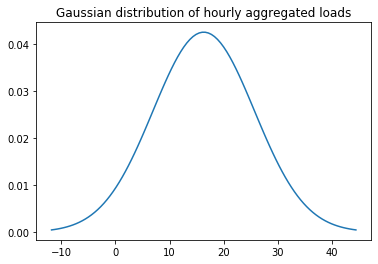

Mean consumption from 2018-04-24 to 2019-04-24 is 16.32116290983607 (-/+ 9.37528340154718).


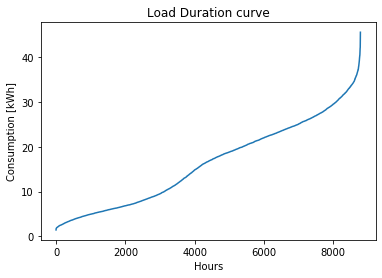

In [47]:
claes_data = pd.read_csv('claes_test.csv', index_col=0, parse_dates=True)
claes_data.head()

# Drop things which is not necessary for testing yet
claes_data.drop(columns=['Temperature','aggLoad'], inplace=True)
claes_data.head()

# Running the functions defined above
df = add_aggregated_col(claes_data)
lst = from_df_to_sorted_lst(df)

calculate_norm_stats(df, plot = True, prnt = True)

plot_load_duration_curve(lst)

In [43]:
claes_data.head()

,V2,V3,V4,V5,V6,V7,V8,V9,V10,AggregatedLoad
TimeDate,,,,,,,,,,
2018-04-24 00:00:00,2.7,0.0,2.72,2.6,1.4,1.2,1.1,1.3,1.6,14.62
2018-04-24 01:00:00,2.6,0.0,2.39,3.2,1.0,1.2,1.1,1.2,1.4,14.09
2018-04-24 02:00:00,2.8,0.0,1.79,3.0,1.3,1.1,1.1,1.4,1.3,13.79
2018-04-24 03:00:00,2.6,0.0,1.78,3.0,1.3,1.2,1.1,1.9,1.1,13.98
2018-04-24 04:00:00,2.6,0.0,2.07,3.3,0.8,1.2,1.1,1.2,1.1,13.37


### Gudmund files

In [14]:
new_appartments = pd.read_csv('../data/new_appartments_district_heating.csv', index_col=0, parse_dates=True)
new_houses = pd.read_csv('../data/new_houses.csv', index_col=0, parse_dates=True)

new_appartments = add_aggregated_col(new_appartments)
new_houses = add_aggregated_col(new_houses)


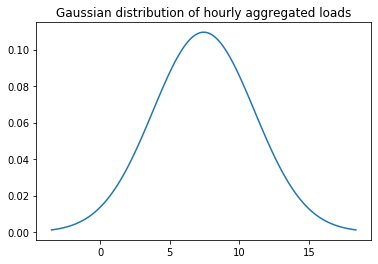

Mean consumption from 2015-10-31 to 2019-05-04 is 7.439339357704217 (-/+ 3.6409452172631145).
new appartments 34


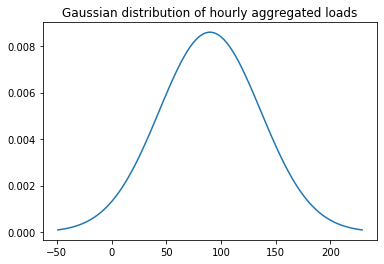

Mean consumption from 2015-10-24 to 2020-01-14 is 90.00036756435216 (-/+ 46.38686991432364).
new houses 48


In [19]:
calculate_norm_stats(new_appartments, plot = True, prnt = True)
print('new appartments '+ str(new_appartments.shape[1]-1))

calculate_norm_stats(new_houses, plot = True, prnt = True)
print('new houses '+ str(new_houses.shape[1]-1))


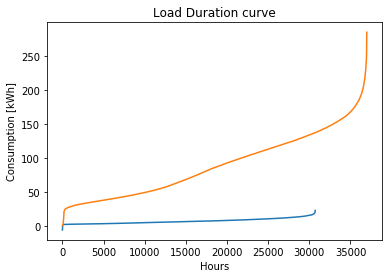

In [18]:
app_lst = from_df_to_sorted_lst(new_appartments)
house_lst = from_df_to_sorted_lst(new_houses)

plot_load_duration_curve(app_lst)
plot_load_duration_curve(house_lst)